In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean


df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)

df['AWS2'] = df['AWS']

features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['doy']  = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2 * np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2 * np.pi * df['doy']  / 365)


In [3]:
split_time = pd.Timestamp('2020-10-15 23:00:00')
df_train = df[df['datetime'] <= split_time].reset_index(drop=True)
df_test  = df[df['datetime'] >  split_time].reset_index(drop=True)

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features]  = scaler.transform(df_test[features])


In [4]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    times = data['datetime'].tolist()
    for i in range(window_size, len(data) - horizon + 1):
        if any((times[j] - times[j-1]).total_seconds() != 3600 
               for j in range(i-window_size+1, i+horizon)):
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


window_size = 1
horizon     = 6

X_train, y_train = make_sequences(df_train, features, target, window_size, horizon)
X_test,  y_test  = make_sequences(df_test,  features, target, window_size, horizon)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test  shapes: (74038, 1, 14) (74038, 6)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_stacked_lstm(
    window_size,
    n_features,
    horizon,
    units1=128,
    units2=64,
    dropout1=0.3,
    dropout2=0.2,
    lr=1e-3
):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))

    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))

    # Dense output với multi-step
    model.add(Dense(horizon, activation='linear'))

    # Compile với learning rate tùy chọn
    from tensorflow.keras.optimizers import Adam
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

window_size = 1
n_features  = len(features)
horizon     = horizon  

model = build_stacked_lstm(
    window_size, n_features, horizon,
    units1=128, units2=64,
    dropout1=0.3, dropout2=0.2,
    lr=1e-3
)
model.summary()

# Callbacks để train
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                        patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es, rlr],
    verbose=1
)


plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,782 (483.52 KB)

 Trainable params: 123,398 (482.02 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - loss: 0.2306 - mae: 0.2098 - val_loss: 0.2475 - val_mae: 0.1618 - learning_rate: 0.0010
Epoch 2/100
 456/8783 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.1386 - mae: 0.1121

KeyboardInterrupt: 

In [ ]:
from scipy.stats import pearsonr

y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2  : {r2:.4f}")

y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
print(f"Overall Pearson R: {pearson_r:.4f}")

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test MSE  : 0.3069
Test RMSE : 0.5540
Test MAE  : 0.2359
Test R^2  : 0.3161
Overall Pearson R: 0.5690


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

C:\Users\giakh\AppData\Local\Temp\ipykernel_18084\2836009533.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


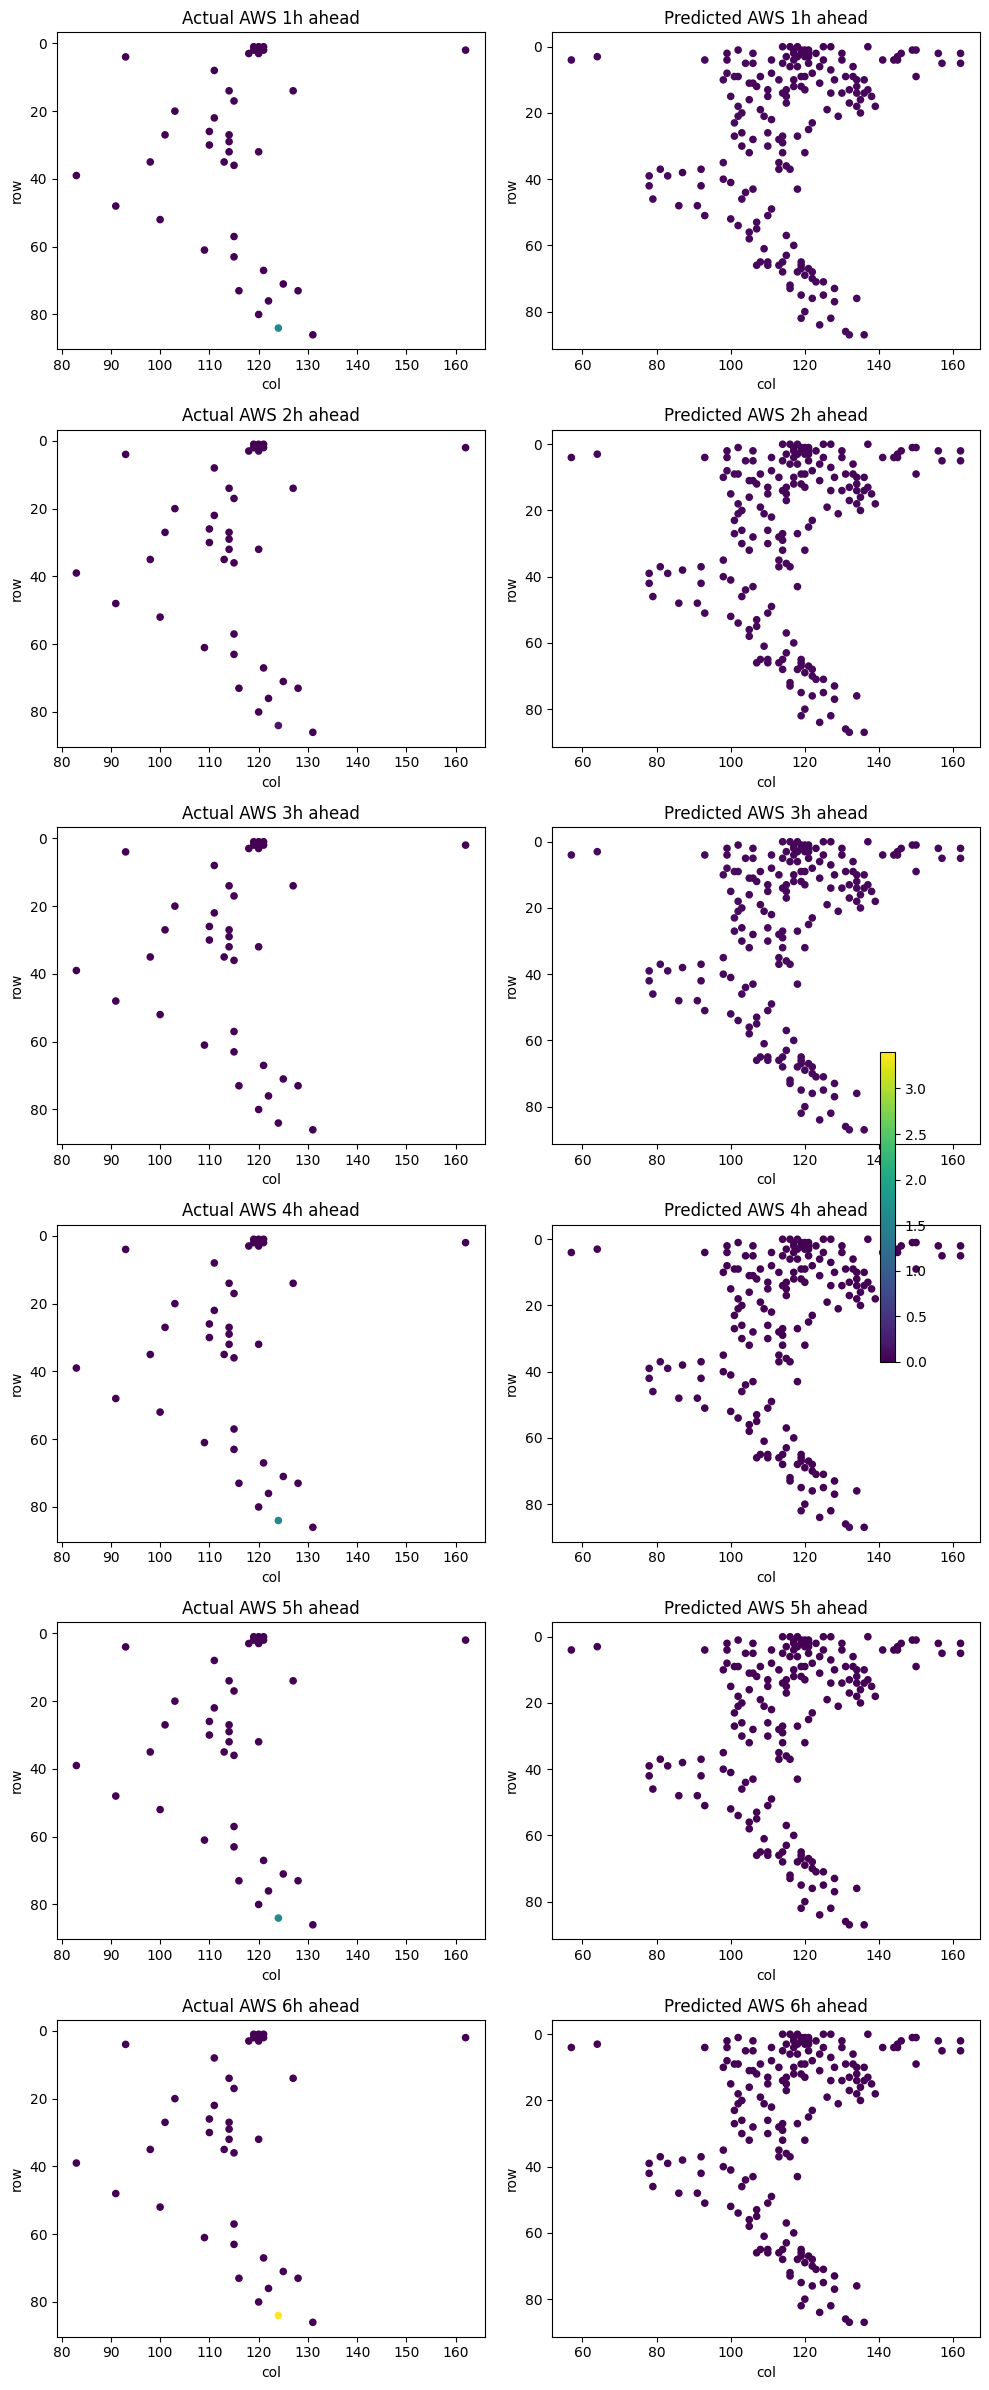

In [ ]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
